In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# Read names from file
with open("nepalese_names.txt", "r") as f:
    names = f.readlines()

In [3]:
names = [name.strip() for name in names]
names[:3]

['Aabha', 'Aabriti', 'Aadya']

In [4]:
# Clean the names
import re
names = [re.sub('[-,.]', '', name) for name in names]
names = [re.sub(r'\(.*\)', '', name) for name in names]
names = [name.lower() for name in names]

In [5]:
len(names)

8328

In [6]:
# Shortest name
temp = [len(name) for name in names]
names[np.argmin(temp)]

'b'

In [7]:
min(len(name) for name in names)

1

In [8]:
max(len(name) for name in names)

16

In [9]:
# Create a set of all the characters that appear in the names and add '.' which works as start and end token
word_set = set('.')
for name in names:
    for char in list(name):
        word_set.add(char)

In [10]:
len(word_set)

27

In [11]:
# Create a matrix of all ones (not zeros for model smoothing) to store the frequency of the occurence of a bigram
word_map = torch.ones((len(word_set), len(word_set)), dtype=torch.int32)

In [12]:
word_map.sum()

tensor(729)

In [13]:
# Create a mapping from the character to its integer value
stoi = {s: i for i, s in enumerate(sorted(word_set))}

In [14]:
# Create a dictionary to map the integer value to its character
itos = {i: s for s, i in stoi.items()}

In [15]:
# Populate the lookup matrix to store the frequency of all the bigrams
for name in names:
    name = ['.'] + list(name) + ['.']
    for char1, char2 in zip(name, name[1:]):
        word_map[stoi[char1], stoi[char2]] +=1
        
word_map[:2]

tensor([[   1,  960,  664,  165,  433,   76,   26,  169,  151,   87,  284,  382,
          153,  443,  463,   45,  680,    3,  702, 1889,  211,  126,   70,   11,
            1,  149,   11],
        [2693,  156,  398,   81,  260,    7,   22,  145,  138,  121,  352,  293,
          541,  702, 2007,    2,  101,    5,  924,  633,  360,   72,  190,   93,
           13,  234,   29]], dtype=torch.int32)

In [16]:
def get_occurences(char1, char2):
    return word_map[stoi[char1], stoi[char2]].item()

get_occurences('l', 'i')

199

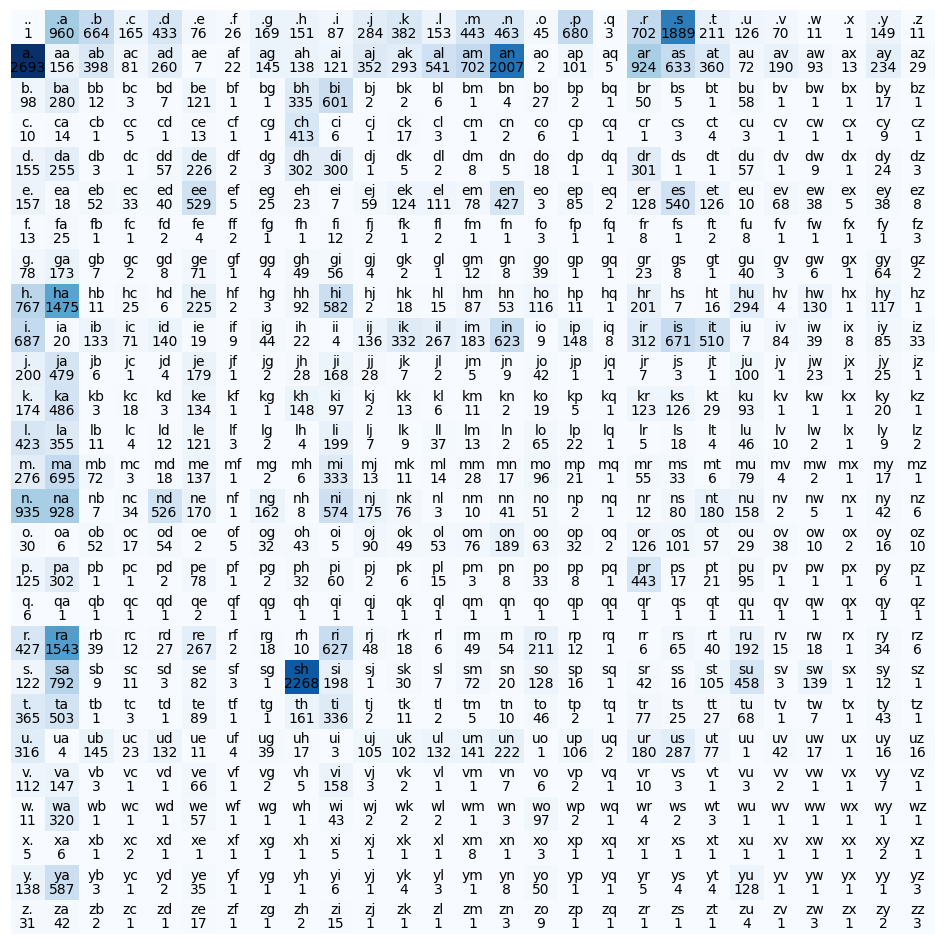

In [17]:
fig, ax = plt.subplots(figsize=(16,12))
ax.imshow(word_map, cmap="Blues")
ax.axis("off")
for i in range(len(word_set)):
    for j in range(len(word_set)):
        lbl = itos[i] + itos[j]
        plt.text(j, i, lbl, ha="center", va="bottom")
        plt.text(j, i, word_map[i,j].item(), ha="center", va="top")

In [18]:
get_occurences('r', 'e')

267

In [19]:
torch.sum(word_map, dim=1, keepdim=True)

tensor([[ 8355],
        [10572],
        [ 1639],
        [  521],
        [ 1743],
        [ 2739],
        [  100],
        [  665],
        [ 4262],
        [ 4604],
        [ 1325],
        [ 1519],
        [ 1387],
        [ 1942],
        [ 4190],
        [ 1189],
        [ 1266],
        [   43],
        [ 3748],
        [ 4541],
        [ 1790],
        [ 2142],
        [  548],
        [  562],
        [   51],
        [  992],
        [  148]])

In [20]:
word_map_normal = torch.div(word_map, torch.sum(word_map, dim=1, keepdim=True))

In [21]:
torch.sum(word_map_normal, dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [22]:
word_map_normal.dtype

torch.float32

In [146]:
# Generate some names using the lookup matrix
gen = torch.Generator().manual_seed(21474835)
idx = 0
for i in range(5):
    out = []
    while True:
        idx = torch.multinomial(word_map_normal[idx], num_samples=1, replacement=True, generator=gen).item()
        if idx == 0:
            break
        out.append(itos[idx])
    print("Name: ", "".join(out))
    

Name:  saamoyaj
Name:  amaramrayan
Name:  nimdabhitar
Name:  bida
Name:  sasha


In [24]:
# Calculate the negative loss likelihood value which is the loss function in this case
log_likelihood = 0.0
num_samples = 0
# for name in names:
for name in ["rameshz"]:
    name = ['.'] + list(name) + ['.']
    for char1, char2 in zip(name, name[1:]):
        print(char1, char2, end='\t')
        prob = word_map_normal[stoi[char1], stoi[char2]]
        print(f"{prob: .6f}")
        log_likelihood += torch.log(prob)
        num_samples += 1
        
print(log_likelihood)
neg_ll = -log_likelihood
print(neg_ll/num_samples)

. r	 0.084022
r a	 0.411686
a m	 0.066402
m e	 0.070546
e s	 0.197152
s h	 0.499449
h z	 0.000235
z .	 0.209459
tensor(-20.9664)
tensor(2.6208)


In [127]:
# Create the training set with inputs and targets
xs = []
ys = []
for name in names:
    name = ['.'] + list(name) + ['.']
    for char1, char2 in zip(name, name[1:]):
        xs.append(stoi[char1])
        ys.append(stoi[char2])
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(f"Number of samples: {xs.nelement()}")

Number of samples: 61854


In [128]:
# Change the inputs to one hot encodings
x_oh = torch.nn.functional.one_hot(xs, num_classes=27).float()
weights = torch.randn((27, 27), requires_grad=True, generator=gen) # Initialize a 27 neurons with random weights
x_oh.shape

torch.Size([61854, 27])

In [129]:
# Training loop
for _ in range(500):
    logits = torch.matmul(x_oh, weights) # Get the logits from doing a forward pass
    counts = logits.exp() # Exponentiate the logits
    probs = torch.div(counts, torch.sum(counts, dim=1, keepdims=True)) # Get the probability distribution (exponentiation and normalization = softmax)
    # Calculate the negative log lokelihood and use add regularization
    loss = -probs[torch.arange(xs.shape[0]), ys].log().mean() + 0.01 * (weights ** 2).mean() 
    print(f"Loss: {loss.item()}")
    weights.grad = None
    loss.backward()
    # Update weights in the opposite direction of gradients
    weights.data += -30 * weights.grad

Loss: 3.8178586959838867
Loss: 3.477139949798584
Loss: 3.253004312515259
Loss: 3.0973052978515625
Loss: 2.9831838607788086
Loss: 2.8949217796325684
Loss: 2.8240368366241455
Loss: 2.765899419784546
Loss: 2.7174124717712402
Loss: 2.6765623092651367
Loss: 2.641963243484497
Loss: 2.61251163482666
Loss: 2.587266206741333
Loss: 2.5654447078704834
Loss: 2.546417236328125
Loss: 2.529691457748413
Loss: 2.514881134033203
Loss: 2.5016801357269287
Loss: 2.4898433685302734
Loss: 2.4791712760925293
Loss: 2.4695000648498535
Loss: 2.4606943130493164
Loss: 2.452641487121582
Loss: 2.445246458053589
Loss: 2.4384286403656006
Loss: 2.4321208000183105
Loss: 2.426265239715576
Loss: 2.4208128452301025
Loss: 2.415721893310547
Loss: 2.4109559059143066
Loss: 2.4064838886260986
Loss: 2.4022791385650635
Loss: 2.398317813873291
Loss: 2.3945794105529785
Loss: 2.3910460472106934
Loss: 2.3877015113830566
Loss: 2.384531259536743
Loss: 2.3815228939056396
Loss: 2.37866473197937
Loss: 2.375946521759033
Loss: 2.37335920333

Loss: 2.2965760231018066
Loss: 2.2965610027313232
Loss: 2.296546220779419
Loss: 2.2965316772460938
Loss: 2.2965171337127686
Loss: 2.2965025901794434
Loss: 2.2964882850646973
Loss: 2.296473979949951
Loss: 2.296459913253784
Loss: 2.2964463233947754
Loss: 2.2964322566986084
Loss: 2.2964184284210205
Loss: 2.2964046001434326
Loss: 2.296391248703003
Loss: 2.2963778972625732
Loss: 2.2963645458221436
Loss: 2.296351432800293
Loss: 2.2963380813598633
Loss: 2.296325206756592
Loss: 2.296312093734741
Loss: 2.2962992191314697
Loss: 2.2962868213653564
Loss: 2.296273708343506
Loss: 2.2962613105773926
Loss: 2.2962486743927
Loss: 2.296236038208008
Loss: 2.2962241172790527
Loss: 2.2962117195129395
Loss: 2.2961995601654053
Loss: 2.2961878776550293
Loss: 2.296175718307495
Loss: 2.29616379737854
Loss: 2.296152114868164
Loss: 2.296140432357788
Loss: 2.296128749847412
Loss: 2.2961175441741943
Loss: 2.2961061000823975
Loss: 2.2960941791534424
Loss: 2.296083450317383
Loss: 2.296072244644165
Loss: 2.296061038970

In [130]:
ys.shape

torch.Size([61854])

In [147]:
# Get some sample names from the network and check if the predictions are same as the ones from the bigram lookup table previously
gen = torch.Generator().manual_seed(21474835)
for _ in range(5):
    out = []
    idx = 0
    
    while True:
        x_enc = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=27).float()
        logits = torch.matmul(x_enc, weights)
        counts = logits.exp()
        probs = torch.div(counts, torch.sum(counts, dim=1, keepdims=True))
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=gen).item()
        if idx == 0:
            break
        out.append(itos[idx])
        

    print("".join(out))

saamoyaj
amaramrayan
nimishaitar
bida
sasha
